## Importing libraries and creating graph

In [7]:
# Importing necessary libraries
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy as sp


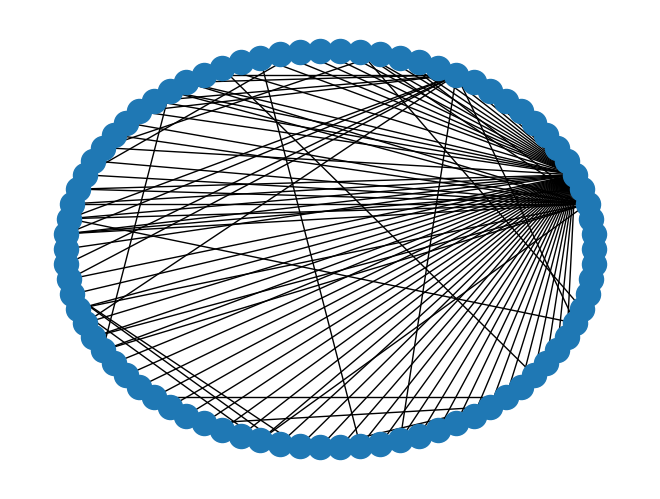

In [8]:
#IMPORTING DATABASE
edges_filename = "edges.csv"
nodes_filename = "nodes.csv"

df_edges = pd.read_csv(edges_filename)
df_nodes = pd.read_csv(nodes_filename)

# Create the graph using the edges CSV
G = nx.from_pandas_edgelist(df_edges, '# source', ' target')
list_of_names=G.nodes()

# Circular plot
nx.draw_circular(G)

# Threshold model (Deterministic updating)
( Testing initially with week10 method )

In [9]:
def simulation_threshold_plot(G,threshold,I,time_limit): #Parameters: the graph, the threshold,
    #the initial outbreak, a limit on the number of iteration to avoid a program never stopping

    #   Initialization of the types
    for node in G.nodes():
        G.nodes[node]['category'] ='Inactive'

    for node in I: #initial outbreak
        G.nodes[node]['category'] ='Active'

    n=G.number_of_nodes()
    
    # Plot using the type for the coloring
    color_map = {'Inactive':'w', 'Active':'r'}  # Map from type to color
    nx.draw_circular(G,node_size=150,with_labels=False, node_color=[color_map[G.nodes[node]['category']] for node in G]) # Plot using the map to decide the color
    plt.show()
    
    # Iteration
    t=1
    
    while t<=time_limit-1:
        t=t+1
                
        for node in G.nodes(): # go over the nodes
            neighbor_active=0   # initialize a counter for the number of active neighbor.
            for neighbor in G.neighbors(node): # go over neighbors and add one for each active neighbor.
                
                if G.nodes[neighbor]['category']=='Active':
                    neighbor_active=neighbor_active+1
                else:
                    neighbor_active=neighbor_active
            
            if neighbor_active>=threshold: # Check if the threshold is reached. If so active the node
                G.nodes[node]['category']='Active'
                
        #we plot only at the end of the iteration
        nx.draw_circular(G,node_size=150,with_labels=False, node_color=[color_map[G.nodes[node]['category']] for node in G]) 
        plt.show()


### Testing with some examples

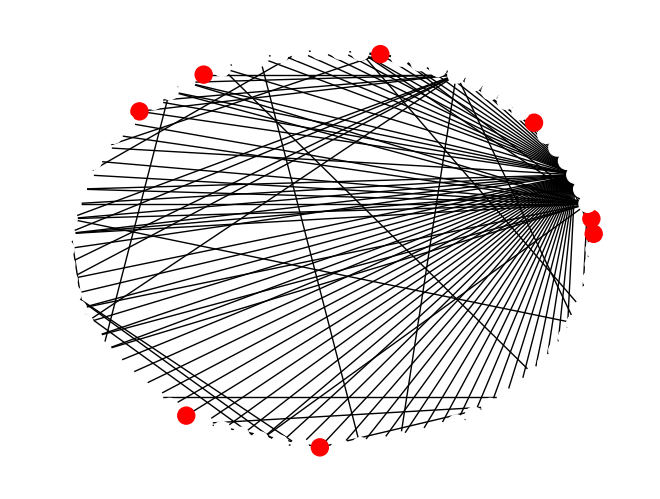

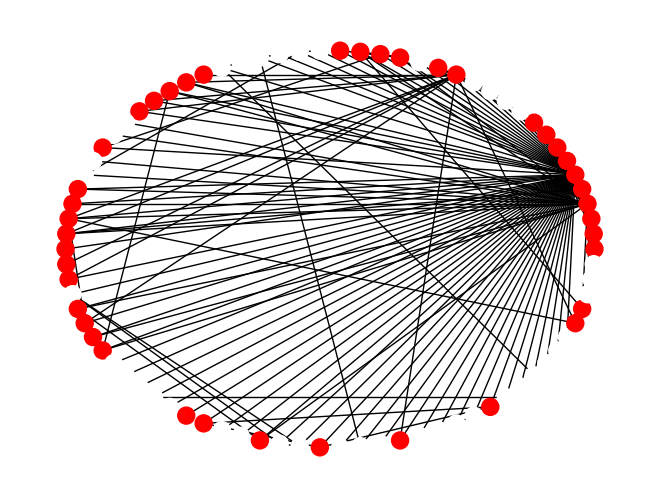

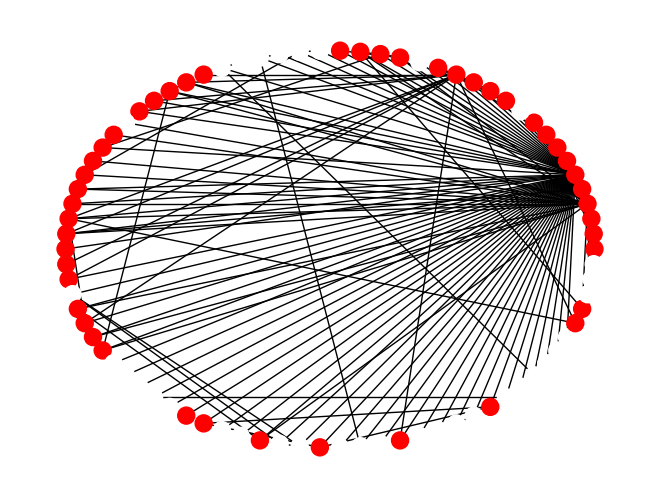

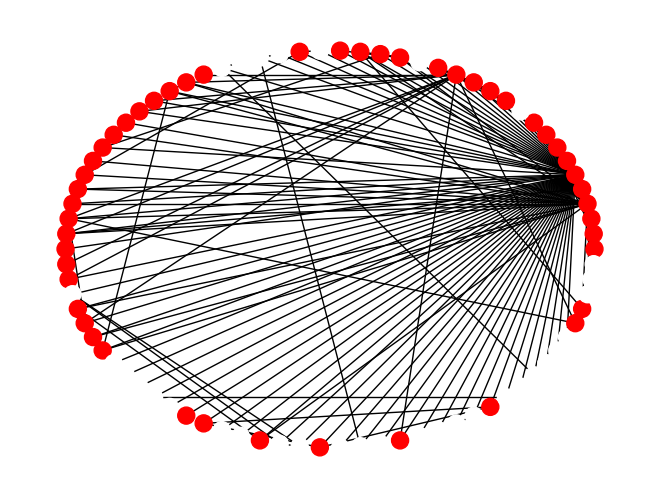

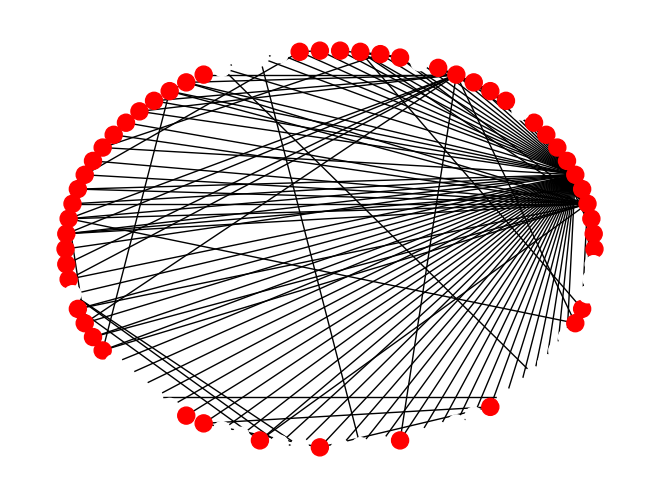

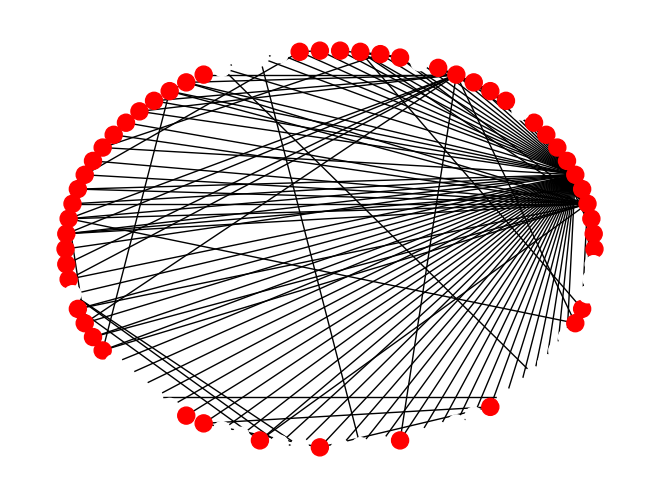

In [10]:
I= [10, 20, 15, 1, 2, 13, 52, 75]
simulation_threshold_plot(G,2,I,6)


We analyse using the function that check the contagion process for every initial node contaminated and creates a list with the results

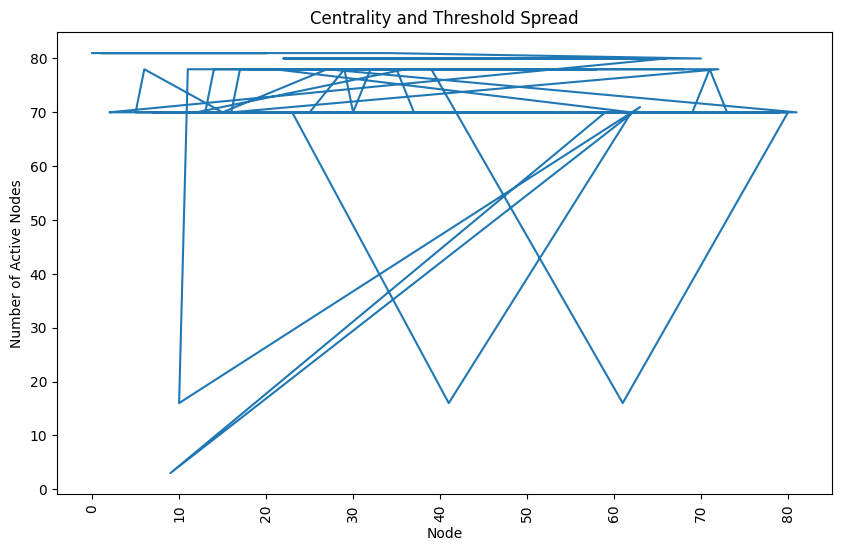

In [44]:
import matplotlib.pyplot as plt

def simulation_threshold_active_end(G, threshold, initial_outbreak, time_limit):
    # Initialize all nodes as 'Inactive'
    for node in G.nodes():
        G.nodes[node]['category'] = 'Inactive'

    # Set initial outbreak nodes as 'Active'
    for node in initial_outbreak:
        G.nodes[node]['category'] = 'Active'

    # Iteration over time limit
    for t in range(1, time_limit):
        for node in G.nodes():
            active_neighbors = sum(G.nodes[neighbor]['category'] == 'Active' for neighbor in G.neighbors(node))
            if active_neighbors >= threshold:
                G.nodes[node]['category'] = 'Active'

    # Count active nodes at the end
    active_count = sum(G.nodes[node]['category'] == 'Active' for node in G.nodes())
    return active_count

def comparison_centrality_threshold_limit(G, threshold, time_limit):
    data_y = []
    for node in G.nodes():
        active_count = simulation_threshold_active_end(G, threshold, [node], time_limit)
        data_y.append(active_count)
    return data_y

# Using your graph 'G' and list of names 'list_of_names'
centrality_threshold = comparison_centrality_threshold_limit(G, 1, 2)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(list_of_names, centrality_threshold)
plt.xlabel('Node')
plt.ylabel('Number of Active Nodes')
plt.title('Centrality and Threshold Spread')
plt.show()


This graph is messy and doesn't give us much infomation, so we will try plotting a different graph:

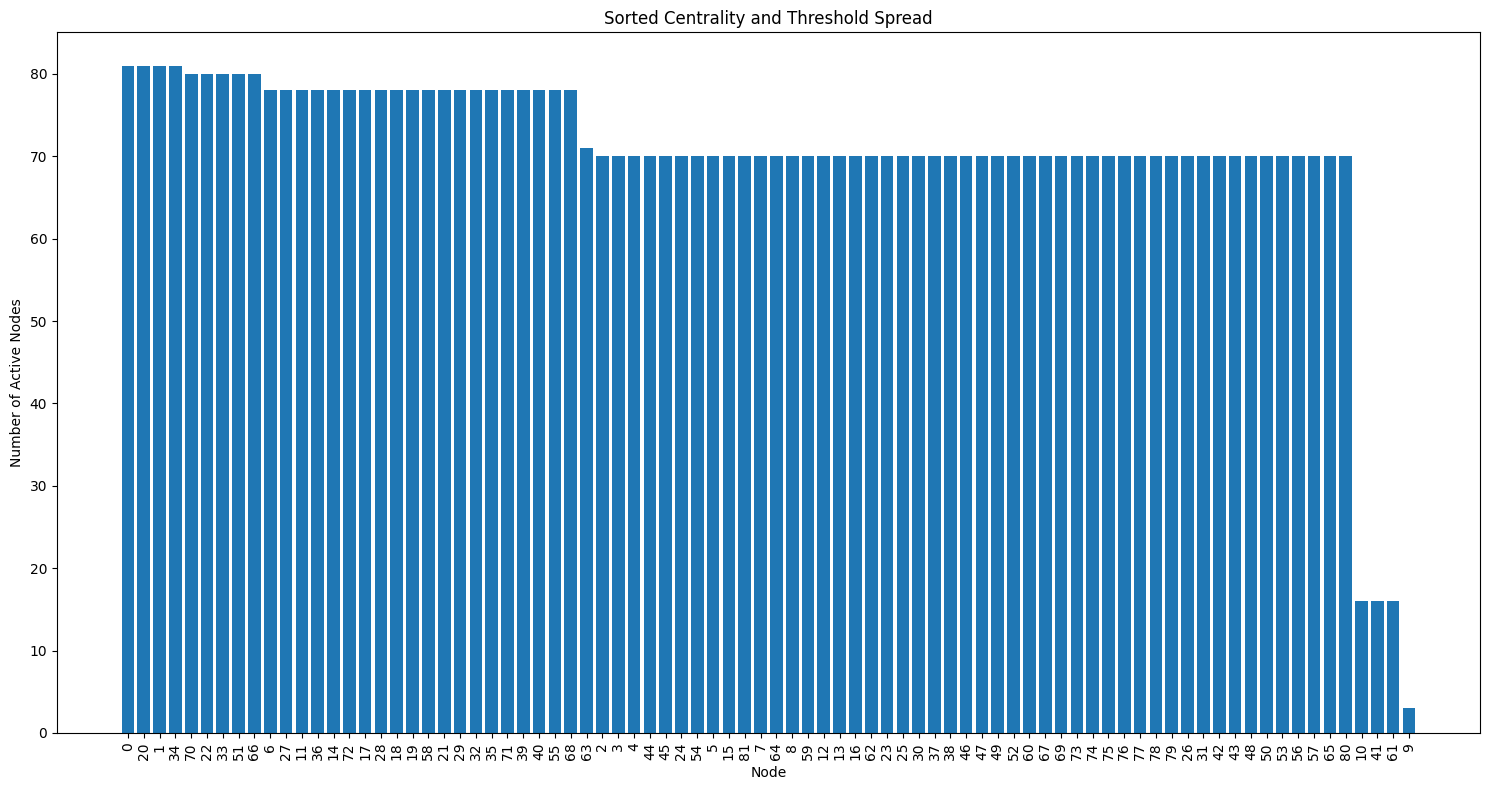

In [24]:
# Convert the lists into a dictionary, sort by the number of active nodes, and split back into two lists
sorted_nodes_active = sorted(zip(list_of_names, centrality_threshold), key=lambda x: x[1], reverse=True)
sorted_nodes, sorted_active = zip(*sorted_nodes_active)

# Plotting the sorted results
plt.figure(figsize=(15, 8))
plt.bar(range(len(sorted_nodes)), sorted_active)
plt.xticks(range(len(sorted_nodes)), sorted_nodes, rotation=90)
plt.xlabel('Node')
plt.ylabel('Number of Active Nodes')
plt.title('Sorted Centrality and Threshold Spread')
plt.tight_layout() 
plt.show()


### To conclude:

- **Disparity in Node Influence:**  Most nodes have a similar influence, but there's a noticeable drop for the least influential nodes.

- **Uniformity Among Most Nodes:** The majority of the nodes have a near-uniform level of influence, with the number of active nodes they influence being relatively similar.

- **Outliers:** There are a few outliers, especially one node at the far right, which has significantly less influence than the others.

## Solution A, Independent Cascade Model 


In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def independent_cascade_model(G, initial_active_nodes, activation_prob):
    active_nodes = set(initial_active_nodes)
    new_active_nodes = set(initial_active_nodes)
    active_nodes_over_time = [set(active_nodes)]  # Store active nodes over time for visualization

    while new_active_nodes:
        current_new_active_nodes = set()
        for node in new_active_nodes:
            neighbors = set(G.neighbors(node)) - active_nodes
            for neighbor in neighbors:
                if random.random() < activation_prob:
                    current_new_active_nodes.add(neighbor)
                    active_nodes.add(neighbor)
        new_active_nodes = current_new_active_nodes
        active_nodes_over_time.append(set(active_nodes))  # Append the current state to the list

    return active_nodes_over_time



### Testing with example
Setting the initial active nodes and activation probability, with 5 randomly chocen initial nodes

In [45]:
initial_active_nodes = random.sample(list(G.nodes()), 5)  
activation_prob = 0.5  

active_nodes_over_time = independent_cascade_model(G, initial_active_nodes, activation_prob)

### Visualization of cascade over time

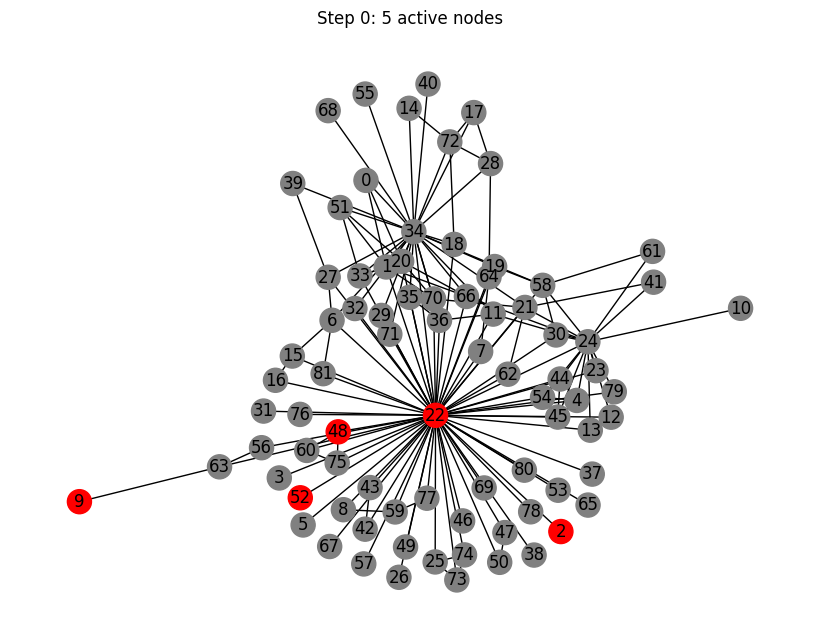

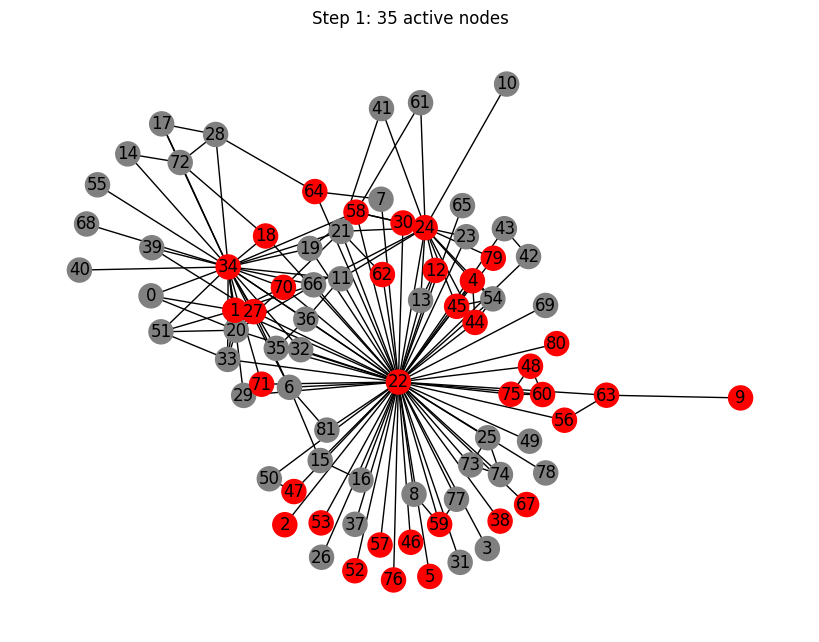

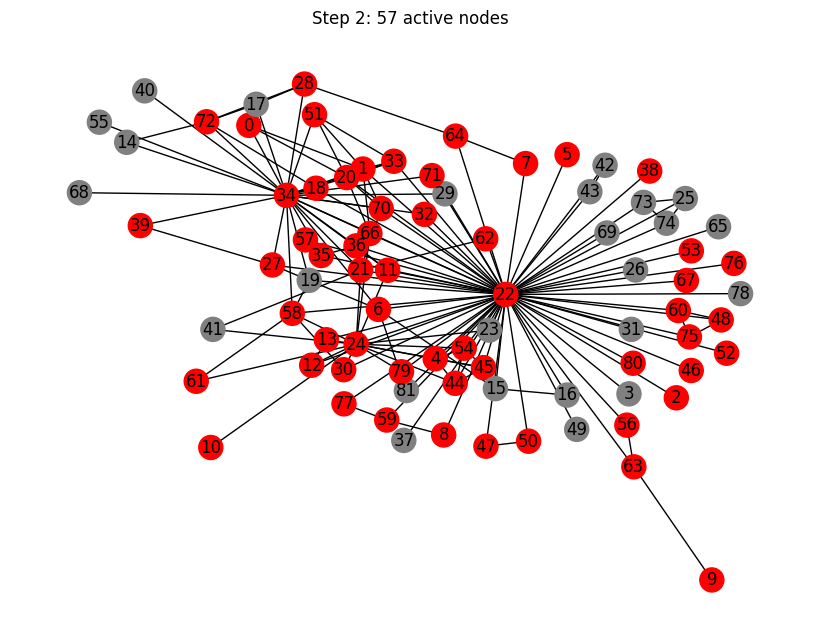

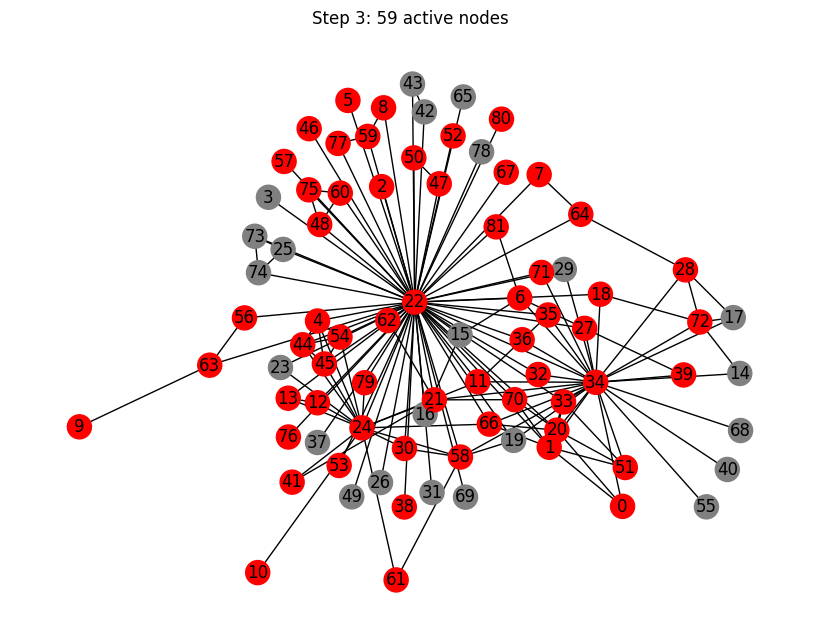

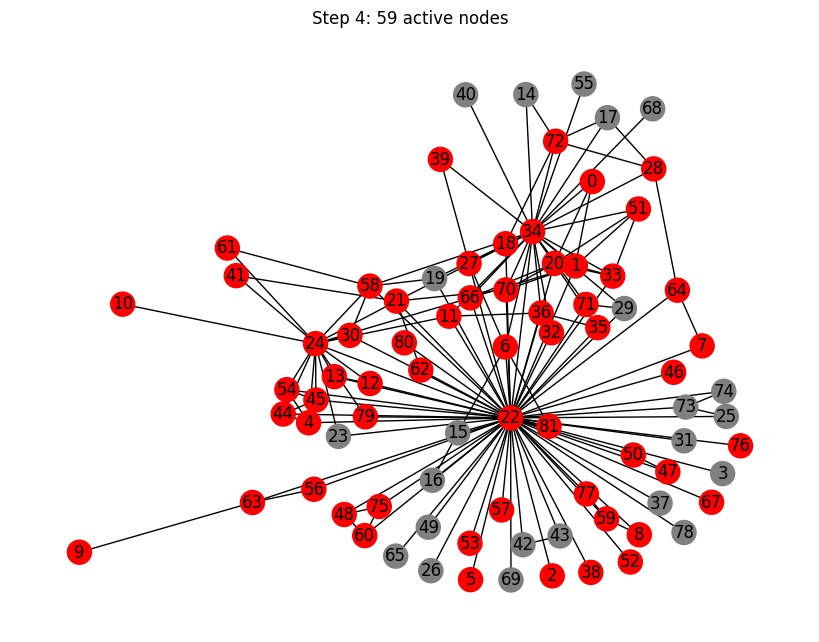

In [46]:
for step, active_nodes in enumerate(active_nodes_over_time):
    plt.figure(figsize=(8, 6))
    node_colors = ['red' if node in active_nodes else 'grey' for node in G.nodes()]
    nx.draw(G, node_color=node_colors, with_labels=True)
    plt.title(f'Step {step}: {len(active_nodes)} active nodes')
    plt.show()

## Part B
Below we simulate the Independent Cascade model on a network to determine the influence of each node on information spread and visualize the average number of nodes activated by each node's influence over multiple simulations. 

The resulting bar chart illustrates the comparative influence of each node within the network.

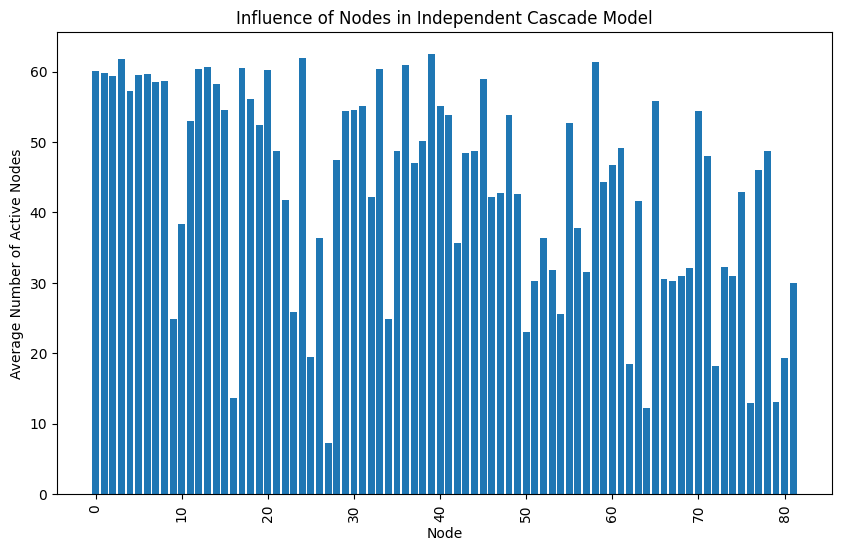

In [39]:
import matplotlib.pyplot as plt
import random

def run_independent_cascade(G, initial_active_nodes, activation_prob):
    active_nodes = set(initial_active_nodes)
    new_active_nodes = set(initial_active_nodes)

    while new_active_nodes:
        current_new_active_nodes = set()
        for node in new_active_nodes:
            neighbors = set(G.neighbors(node)) - active_nodes
            for neighbor in neighbors:
                if random.random() < activation_prob:
                    current_new_active_nodes.add(neighbor)
                    active_nodes.add(neighbor)
        new_active_nodes = current_new_active_nodes

    return active_nodes

def comparison_independent_cascade(G, activation_prob, num_simulations):
    data_y = []
    for node in G.nodes():
        active_count_total = 0
        # Run multiple simulations for each node to get an average influence value
        for _ in range(num_simulations):
            active_nodes = run_independent_cascade(G, [node], activation_prob)
            active_count_total += len(active_nodes)
        average_active_count = active_count_total / num_simulations
        data_y.append(average_active_count)
    return data_y

# Set the activation probability and the number of simulations
activation_prob = 0.5
num_simulations = 10  # Number of simulations to average over for each node

# Run the comparison function
centrality_cascade = comparison_independent_cascade(G, activation_prob, num_simulations)

# Assuming 'list_of_names' is a list of node labels in the same order as nodes in G
# Plotting the results
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.bar(range(len(list_of_names)), centrality_cascade)
plt.xlabel('Node')
plt.ylabel('Average Number of Active Nodes')
plt.title('Influence of Nodes in Independent Cascade Model')
plt.show()


### Conclusions:

1. **Variability in Influence**: There's a clear variability in how influential each node is. Some nodes have a much higher average number of activations than others, indicating they are key players in spreading information or influence across the network.

2. **No Single Dominant Node**: While some nodes are more influential than others, there doesn't appear to be a single node that overwhelmingly dominates the influence spread. This suggests a distributed nature of influence rather than a central point of control.

3. **Target Nodes for Intervention**: If the goal is to maximize or  prevent spread, the nodes with higher bars would be the primary targets for intervention due to their higher average influence.